In [1]:
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
%matplotlib inline
import warnings
import duckdb
warnings.filterwarnings('ignore')

In [6]:
df = pd.read_parquet("D:/sudesh/aerospace endto end/notebook/data/sample_sensor_data.parquet", engine="pyarrow")

In [7]:
df.head()

,sensor_id,timestamp,reading_type,value,battery_level
0,sensor_5,2025-06-05 13:48:48.068905,humidity,28.20,77.90
1,sensor_2,2025-06-05 13:43:48.068905,humidity,15.73,48.88
2,sensor_1,2025-06-05 13:38:48.068905,temperature,25.85,62.65
3,sensor_5,2025-06-05 13:33:48.068905,temperature,24.68,53.57
4,sensor_5,2025-06-05 13:28:48.068905,temperature,24.60,29.22


In [8]:
df.shape

(30, 5)

In [10]:
con = duckdb.connect(database=':memory:')
con.execute("CREATE TABLE sensors AS SELECT * FROM df")
print("\nDuckDB Schema:")
print(con.execute("DESCRIBE sensors").df())



DuckDB Schema:
     column_name   column_type null   key default extra
0      sensor_id       VARCHAR  YES  None    None  None
1      timestamp  TIMESTAMP_NS  YES  None    None  None
2   reading_type       VARCHAR  YES  None    None  None
3          value        DOUBLE  YES  None    None  None
4  battery_level        DOUBLE  YES  None    None  None


### CHECK MISSING VALUES

In [11]:
df.isna().sum()

sensor_id        0
timestamp        0
reading_type     0
value            0
battery_level    0
dtype: int64

### check the duplicate

In [12]:
df.duplicated().sum()

np.int64(0)

### check the data type

In [13]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 30 entries, 0 to 29
Data columns (total 5 columns):
 #   Column         Non-Null Count  Dtype         
---  ------         --------------  -----         
 0   sensor_id      30 non-null     object        
 1   timestamp      30 non-null     datetime64[ns]
 2   reading_type   30 non-null     object        
 3   value          30 non-null     float64       
 4   battery_level  30 non-null     float64       
dtypes: datetime64[ns](1), float64(2), object(2)
memory usage: 1.3+ KB


### check the statistics of data

In [14]:
df.describe()

,timestamp,value,battery_level
count,30,30.000000,30.000000
mean,2025-06-05 12:36:18.068904960,23.272667,60.379667
min,2025-06-05 11:23:48.068905,11.240000,25.340000
25%,2025-06-05 12:00:03.068904960,17.695000,43.720000
50%,2025-06-05 12:36:18.068904960,25.135000,57.590000
75%,2025-06-05 13:12:33.068904960,27.817500,77.945000
max,2025-06-05 13:48:48.068905,33.290000,98.730000
std,NaN,6.603623,22.126299


### Explore data

In [15]:
print("\nInvalid Values Check:")
print(con.execute("""
    SELECT 
        SUM(value IS NULL) as missing_values,
        SUM(battery_level < 0 OR battery_level > 100) as invalid_battery,
        MIN(value) as min_value,
        MAX(value) as max_value
    FROM sensors
""").df())


Invalid Values Check:
   missing_values  invalid_battery  min_value  max_value
0             0.0              0.0      11.24      33.29


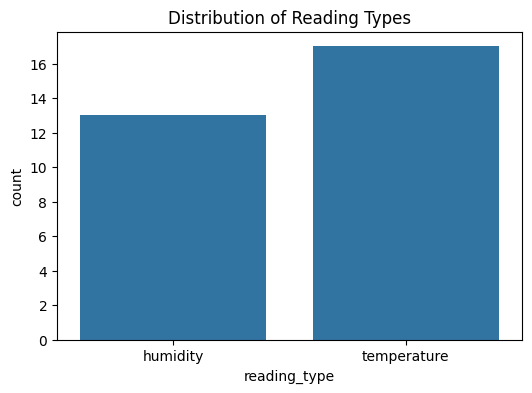

In [16]:
plt.figure(figsize=(6,4))
sns.countplot(x="reading_type", data=df)
plt.title("Distribution of Reading Types")
plt.show()

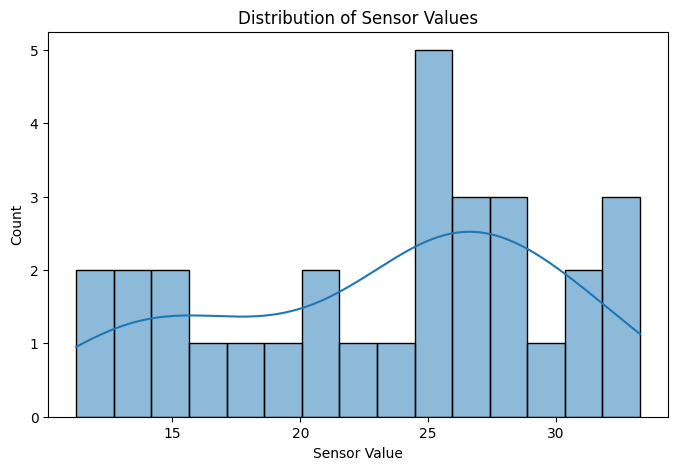

In [17]:
plt.figure(figsize=(8,5))
sns.histplot(df['value'], bins=15, kde=True)
plt.title("Distribution of Sensor Values")
plt.xlabel("Sensor Value")
plt.show()

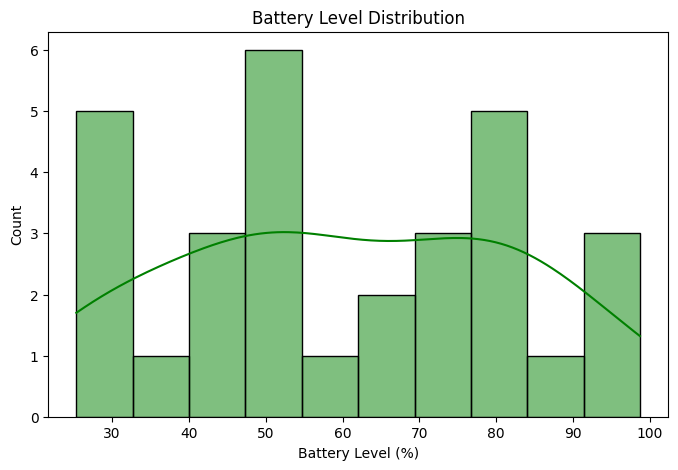

In [18]:
plt.figure(figsize=(8,5))
sns.histplot(df['battery_level'], bins=10, kde=True, color="green")
plt.title("Battery Level Distribution")
plt.xlabel("Battery Level (%)")
plt.show()

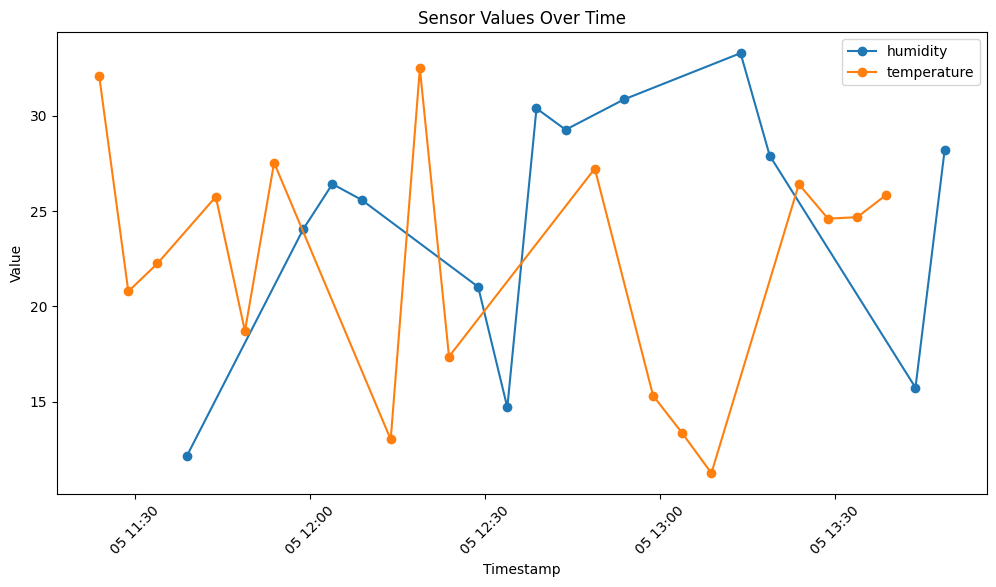

In [19]:
plt.figure(figsize=(12,6))
for rtype in df['reading_type'].unique():
    subset = df[df['reading_type'] == rtype]
    plt.plot(subset['timestamp'], subset['value'], marker='o', label=rtype)

plt.title("Sensor Values Over Time")
plt.xlabel("Timestamp")
plt.ylabel("Value")
plt.legend()
plt.xticks(rotation=45)
plt.show()

Sensor-wise Stats:
               value                         battery_level                \
                mean    min    max       std          mean    min    max   
sensor_id                                                                  
sensor_1   24.770000  12.12  30.86  7.407554     56.048000  25.34  98.73   
sensor_2   21.563333  15.31  32.49  6.318486     60.761667  29.62  94.81   
sensor_3   29.440000  25.59  33.29  5.444722     48.290000  43.47  53.11   
sensor_4   24.037143  14.69  32.10  6.232393     62.837143  26.97  82.70   
sensor_5   21.781000  11.24  30.39  7.084157     63.014000  27.00  93.70   

                      
                 std  
sensor_id             
sensor_1   27.602860  
sensor_2   25.825804  
sensor_3    6.816509  
sensor_4   21.514505  
sensor_5   22.342526  


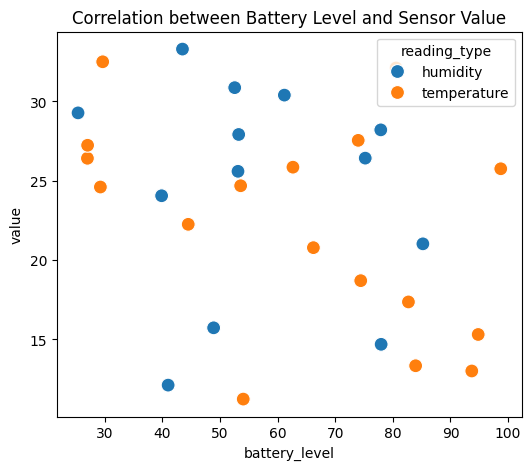

In [20]:
sensor_stats = df.groupby("sensor_id")[["value", "battery_level"]].agg(["mean","min","max","std"])
print("Sensor-wise Stats:")
print(sensor_stats)

# -----------------------------
# 6. Correlation between value and battery level
# -----------------------------
plt.figure(figsize=(6,5))
sns.scatterplot(x="battery_level", y="value", hue="reading_type", data=df, s=100)
plt.title("Correlation between Battery Level and Sensor Value")
plt.show()